添加一个tool

In [1]:
from langchain_tavily import TavilySearch
import dotenv
import os
dotenv.load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

'''定义网络搜索工具'''
tool = TavilySearch(max_results=2)
tools = [tool]

tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [2]:
'''LLM层'''
import os
from langchain.chat_models import init_chat_model
import dotenv

dotenv.load_dotenv()
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

In [3]:
'''将工具合并到graph中'''
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [4]:
'''创建函数运行工具'''
# 具体方法是将工具添加到一个名为 BasicToolNode 的新节点，该节点会检查状态中的最新消息，并在消息包含 tool_calls 时调用工具
import json

from langchain_core.messages import ToolMessage

'''定义工具节点'''
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 在Python中，`:=`符号被称为“海象运算符”，用于在表达式中进行赋值操作。它允许在条件判断中直接对变量进行赋值。
        if (messages := inputs.get("messages", [])):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [5]:
'''定义工具路由'''
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

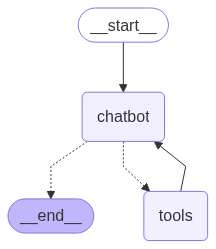

In [6]:
'''可视化'''
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
'''向机器人提问'''
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: [{'text': '让我帮您搜索关于杭州的最新新闻。由于您想了解最近的新闻，我会使用新闻搜索并设置较近的时间范围。', 'type': 'text'}, {'id': 'toolu_013Tv89eePkosc3XdcVqrRih', 'input': {'query': '杭州 最新新闻', 'time_range': 'week', 'topic': 'news'}, 'name': 'tavily_search', 'type': 'tool_use'}]
Assistant: {"query": "\u676d\u5dde \u6700\u65b0\u65b0\u95fb", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.metal.com/en/newscontent/103388031", "title": "First Quantum Takes Small Step on Long Road to Restart Its Copper Mine in Panama - Shanghai Metals Market", "score": 0.087915756, "published_date": "Fri, 20 Jun 2025 15:20:48 GMT", "content": "*   [NEXT ARTICLE 11 days ago ### [SMM Steel Market Morning Briefing] General Administration of Customs: In May, China's exports reached 2.28 trillion yuan, up 6.3% YoY](https://www.metal.com/en/newscontent/103366604) *   [[SMM Steel Morning Meeting Summary] Number of steel mills undergoing maintenance increases, weak balance of supply and demand can be temp

In [ ]:
'''完整代码'''
# ToolNode, tools_condition 作为预先构建的组件

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()